In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

In [2]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

In [3]:
prof_dir = '../data/processed/iprg2012/profiling'
# profiling data extracted from bf_closed.prof, bf_oms.prof, bf_oms_ann.prof
profiling = pd.read_csv(os.path.join(prof_dir, 'profiling.txt'), sep='\t')

In [4]:
profiling_bar = profiling[['select_candidates', 'score_candidates', 'read_lib']].copy()
profiling_bar['io'] = (profiling['read_queries'] +
                       profiling['write_results'] +
                       profiling['other'])
profiling_bar.columns = ['Candidate selection', 'Candidate ranking',
                         'IO (library)', 'IO (other)']

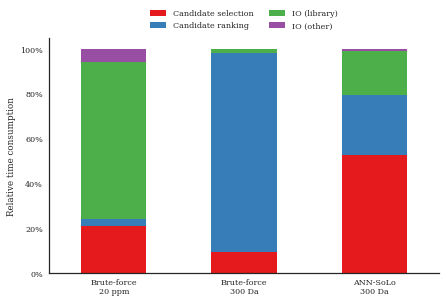

In [5]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

profiling_bar.plot.bar(ax=ax, stacked=True)

ax.set_ylabel('Relative time consumption')

xtick_labels = (profiling['mode'].map(str) + '\n' +
                profiling['precursor_tol_mass'].map(str) + ' ' +
                profiling['precursor_tol_mode'].map(str))
ax.set_xticklabels(xtick_labels, rotation='horizontal')

ax.yaxis.set_major_formatter(mticker.PercentFormatter())

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

sns.despine()

plt.savefig('profiling.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()